In [1]:
import pandas as pd
import pandas.io.sql as pd_sql
from pandas import Series, DataFrame, Panel
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from pylab import *
import datetime as date
import scipy.optimize
import scipy.stats
import seaborn as sns
import matplotlib.patches as mpatches

In [242]:
path = "/Users/pkelly04/Documents/NEPADS Dumps/"
file = "NEPADS_20171001to20180509.xlsx"
sheet = "NEPADS_20171001to20180509"

## read excel file ###################################################################################################################
DB_Dump = pd.ExcelFile(path+file)
dmp_parse = DB_Dump.parse(sheetname=sheet)
#####################################################################################################################################
# Add a column for the Fiscal Year, add a year to Due Dates: Oct - Dec
dmp_parse['Fiscal Year'] = dmp_parse['Due Date'].dt.year
dmp_parse.loc[(dmp_parse['Due Date'].dt.month > 9 ) & (dmp_parse['Due Date'].dt.month <= 12), 'Fiscal Year'] = dmp_parse['Fiscal Year'] +1

dmp_parse['Type Grouped'] = dmp_parse['Type']
# Lump Drafts
dmp_parse.loc[(dmp_parse['Type'] == 'DEIS') | 
              (dmp_parse['Type'] == 'RDEIS') | 
              (dmp_parse['Type'] == 'SDEIS'), 
              'Type Grouped'] = 'Draft EIS'
#Lump Finals
dmp_parse.loc[(dmp_parse['Type'] == 'FEIS') |
              (dmp_parse['Type'] == 'RFEIS') | 
              (dmp_parse['Type'] == 'SFEIS'), 
              'Type Grouped'] = 'Final EIS'

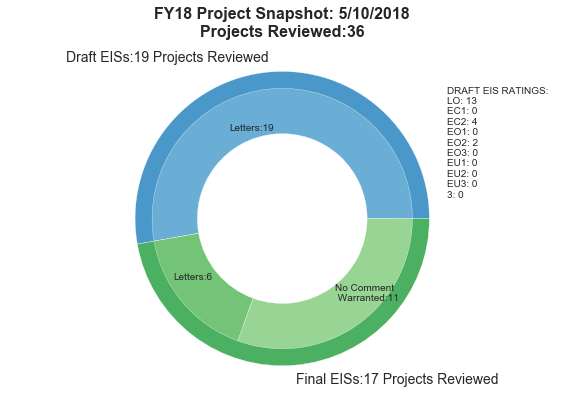

In [243]:
# Make data: I have 3 groups and 7 subgroups
fig, ax = plt.subplots()

# Create colors
a, b, c, d=[plt.cm.Blues, plt.cm.Greens, plt.cm.YlOrBr, plt.cm.Reds]
pp = PdfPages('DblPiedft'+date.datetime.now().strftime("%m_%d_%Y")+'.pdf')

group_names=['Draft EISs', 'Final EISs']

group_size=[len(dmp_parse.loc[(dmp_parse['Type Grouped'] == 'Draft EIS')]),
            len(dmp_parse.loc[(dmp_parse['Type Grouped'] == 'Final EIS')])] #dynamic
        
group_names=['Draft EISs:'+str(group_size[0]) +' Projects Reviewed', 
             'Final EISs:'+str(group_size[1]) +' Projects Reviewed']
                
cmb_g = pd.DataFrame({'names': group_names,
                      'size': group_size})

cmb_g.loc[(cmb_g['size'] == 0), 'names'] = ''
        
# SUBGROUPS        
        
subgroup_size=[len(dmp_parse.loc[(dmp_parse['Type Grouped'] == 'Draft EIS') & (dmp_parse['Resolution Status'] == 'LTR')]),
               len(dmp_parse.loc[(dmp_parse['Type Grouped'] == 'Draft EIS') & (dmp_parse['Resolution Status'] == 'NCW')]),
               len(dmp_parse.loc[(dmp_parse['Type Grouped'] == 'Final EIS') & (dmp_parse['Resolution Status'] == 'LTR')]),# 
               len(dmp_parse.loc[(dmp_parse['Type Grouped'] == 'Final EIS') & (dmp_parse['Resolution Status'] == 'NCW')])] #dynamic
        
subgroup_names=['Letters:'+str(subgroup_size[0]), 
                'No Comment \n Warranted:'+str(subgroup_size[1]), 
                'Letters:'+str(subgroup_size[2]), 
                'No Comment \n Warranted:'+str(subgroup_size[3])]
        
cmb_s = pd.DataFrame(
                {'names': subgroup_names,
                 'size': subgroup_size
                })

cmb_s.loc[(cmb_s['size'] == 0), 'names'] = ''
ax.axis('equal')


# First Ring (outside)
mypie, _ = ax.pie(group_size, radius=1.3, labels=cmb_g['names'], colors=[a(0.6), b(0.6)] )

plt.setp(mypie, width=0.3, edgecolor='white')
plt.setp(_, size=14)
    
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.4-0.25, labels=cmb_s['names'], labeldistance=0.7, colors=[
                   a(0.5), 
                   a(0.4), 
                   b(0.5), 
                   b(0.4)])


plt.setp(mypie2, width=0.4, edgecolor='white')
plt.setp(_, size=10)


plt.suptitle('FY18 Project Snapshot: 5/10/2018' + '\n' + 'Projects Reviewed:' + str(len(dmp_parse)), size=16, va='baseline', weight='bold', y = .9)
#fig.subplots_adjust(top=0.85)
plt.tight_layout(rect=[0, 0.05, 1, 0.83])

blue_patch = mpatches.Patch(color='white', label= 'DRAFT EIS RATINGS:' + '\n'
                            'LO: ' + str(len(dmp_parse.loc[(dmp_parse['Type Grouped'] == 'Draft EIS') & (dmp_parse['Public Rating'] == 'LO')])) + '\n'
                            'EC1: '+ str(len(dmp_parse.loc[(dmp_parse['Type Grouped'] == 'Draft EIS') & (dmp_parse['Public Rating'] == 'EC1')]))+ '\n'
                            'EC2: '+ str(len(dmp_parse.loc[(dmp_parse['Type Grouped'] == 'Draft EIS') & (dmp_parse['Public Rating'] == 'EC2')]))+ '\n'
                            'EO1: '+ str(len(dmp_parse.loc[(dmp_parse['Type Grouped'] == 'Draft EIS') & (dmp_parse['Public Rating'] == 'EO1')]))+ '\n'
                            'EO2: '+ str(len(dmp_parse.loc[(dmp_parse['Type Grouped'] == 'Draft EIS') & (dmp_parse['Public Rating'] == 'EO2')]))+ '\n'
                            'EO3: '+ str(len(dmp_parse.loc[(dmp_parse['Type Grouped'] == 'Draft EIS') & (dmp_parse['Public Rating'] == 'EO3')]))+ '\n'
                            'EU1: '+ str(len(dmp_parse.loc[(dmp_parse['Type Grouped'] == 'Draft EIS') & (dmp_parse['Public Rating'] == 'EU1')]))+ '\n'
                            'EU2: '+ str(len(dmp_parse.loc[(dmp_parse['Type Grouped'] == 'Draft EIS') & (dmp_parse['Public Rating'] == 'EU2')]))+ '\n'
                            'EU3: '+ str(len(dmp_parse.loc[(dmp_parse['Type Grouped'] == 'Draft EIS') & (dmp_parse['Public Rating'] == 'EU3')]))+ '\n'
                            '3: '+ str(len(dmp_parse.loc[(dmp_parse['Type Grouped'] == 'Draft EIS') & (dmp_parse['Public Rating'] == '3')])) 
                           )

plt.legend(handles=[blue_patch])

pp.savefig()
pp.close()
 
# show it
plt.show()

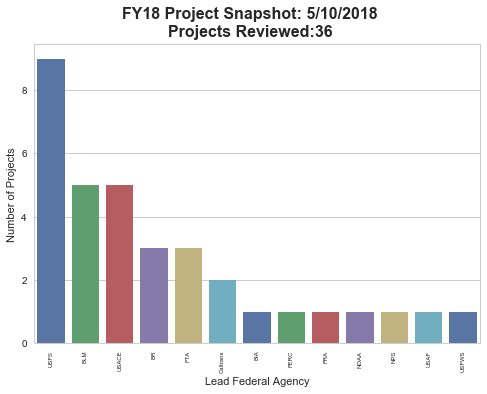

In [244]:
### Barcharts for Global Project Counts By Agency #########################################
sns.set_style("whitegrid")
fig = plt.figure()
pp = PdfPages('AgencyBar'+date.datetime.now().strftime("%m_%d_%Y")+'.pdf')

## DATA SUBSETTING ##
a = dmp_parse.groupby("Lead Agencies").agg(Series.nunique)
a.reset_index(inplace = True)
a.sort_values('Main ID', ascending=False, inplace = True)

ax = sns.barplot(x='Lead Agencies',y='Main ID',data=a, palette="deep")

## PLOT FORMATTING ##
#plt.xticks(rotation=70)
ax.set_ylabel('Number of Projects')
ax.set_xlabel('Lead Federal Agency')
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90, fontsize=6)
plt.suptitle('FY18 Project Snapshot: 5/10/2018' + '\n' + 'Projects Reviewed:' + str(len(dmp_parse)), size=16, va='baseline', weight='bold', y = .9)
## SAVE FIGURE ##
pp.savefig()
pp.close()

## SHOW PLOT INLINE ##
plt.show()
plt.clf()

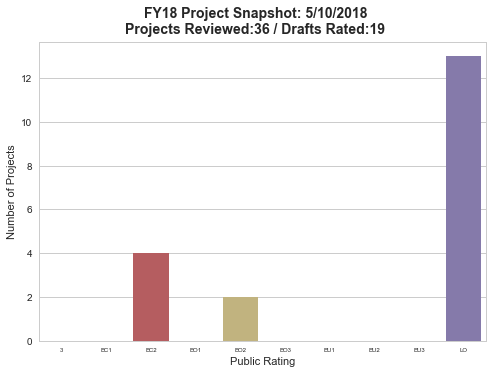

In [245]:
### Barcharts for Global Project Counts By Rating #########################################
sns.set_style("whitegrid")
fig = plt.figure()
pp = PdfPages('RatingBar'+date.datetime.now().strftime("%m_%d_%Y")+'.pdf')

## DATA SUBSETTING ##
a = dmp_parse.groupby("Public Rating").agg(Series.nunique)
a.reset_index(inplace = True)
a.sort_values('Main ID', ascending=False, inplace = True)

d = {'Public Rating': ['LO','EC1','EC2','EO1','EO2','EO3','EU1','EU2','EU3','3'], 'Main ID': [0,0,0,0,0,0,0,0,0,0]}
df = pd.DataFrame(data=d)

result = pd.merge(a, df, on=['Public Rating','Main ID'], how='outer')
bartbl = pd.pivot_table(result, values='Main ID', index=['Public Rating'], aggfunc=np.sum).reset_index()

ax = sns.barplot(x='Public Rating',y='Main ID',data=bartbl, palette="deep")

## PLOT FORMATTING ##
#plt.xticks(rotation=70)
ax.set_ylabel('Number of Projects')
ax.set_xlabel('Public Rating')
ax.set_xticklabels(ax.xaxis.get_majorticklabels(),  fontsize=6)
plt.suptitle('FY18 Project Snapshot: 5/10/2018' + '\n' + 'Projects Reviewed:' + str(len(dmp_parse)) + ' / ' + 'Drafts Rated:' + str(len(dmp_parse.loc[(dmp_parse['Type Grouped'] == 'Draft EIS')])) , size=14, va='baseline', weight='bold', y = .9)
## SAVE FIGURE ##
pp.savefig()
pp.close()

## SHOW PLOT INLINE ##
plt.show()
plt.clf()